# Get Daily Station Data from NOAA/NCEI's Cliamte Data Online (API)
## Written By Jared Rennie (@jjrennie)
Taps into the Cliamte Data Online (API) to get daily station data. This notebook will continually be built to supplement the Regional Climate Center's ACIS tools, should that go away for... "Reasons"
- CDO Webpage: https://www.ncei.noaa.gov/cdo-web/
- API: https://www.ncdc.noaa.gov/cdo-web/webservices

### What You Need
First off, the entire codebase works in Python 3.12 or higher. In addition to base Python, you will need the following packages installed: 
- <a href='https://pypi.org/project/noaa-cdo-api/' target="_blank">NOAA-CDO-API</a> (python wrapper to access the api)
- pandas (to slice annd dice the data)

The "easiest" way is to install these is by installing <a href='https://www.anaconda.com' target="_blank">anaconda</a>, and then applying <a href='https://conda-forge.org/' target="_blank">conda-forge</a>. Afterward, then you can install the above packages. 

### Importing Packages
Assuming you did the above, it should (in theory) import everything no problem:

In [1]:
# Import packages
import asyncio
import pandas as pd
import matplotlib.pyplot as plt
from noaa_cdo_api import NOAAClient, Extent

### Get your API Token
In order to access the API, you need a token. It's free and you can request one here: https://www.ncdc.noaa.gov/cdo-web/token

Once you have it, put the token in below. It is unique to you, so **DO NOT SHARE.** 

Also note that the API is limited to  five requests per second and 10,000 requests per day.

In [2]:
# Secret Token (DO NOT SHARE)
apiToken='INSERT-TOKEN-HERE'

### Input parameters
These parameters are specific to what data you would need
- Station Identifier. If you're not sure, you can look up <a href="https://www.ncdc.noaa.gov/cdo-web/search" target="_blank">here</a>
- start and end dates (YYYY-MM-DD)

In [3]:
# Define user inputs
ghcndID='USW00003812'
startDate="2024-01-01"
endDate="2024-12-31"

### Get the data
This particular block of code uses the noaa-cdo-api wrapper to set up the type of data we want. Some things to note
- We are only looking at GHCNd, but there are other datasets to consider
- We are pulling down 3 variabls, maximum temperature ('TMAX'), minimum temperature ('TMIN'), and precipitation ('PRCP'). There are many other variables to consider too.
- The data typically comes in metric (Celsius and mm), but we are switching to imperial units (Fahrenheit and inches).

In [4]:
async def get_data():
    async with NOAAClient(token=apiToken) as client:
        global data
        data = await client.get_data(
            datasetid="GHCND",
            startdate=startDate,
            enddate=endDate,
            stationid="GHCND:"+ghcndID,
            units="standard",
            datatypeid=["TMAX","TMIN","PRCP"],
            includemetadata=False,
            limit=1000,
        )
        print("SUCCESS")

Note that it didn't print "SUCCESS." This just sets up the asynchronous function. Now we run the function and see if it works. If not, you may have to run it a few times, or change the size of your request

In [5]:
await get_data()

SUCCESS


### Cleanup the Data
If it successfully ran without errors, then it provides a JSON of the resulting query. Let's convert it to a Pandas dataframe to make it look nicer.

In [6]:
# Convert to Pandas
inData = pd.DataFrame(data['results'])
inData

,date,datatype,station,attributes,value
0,2024-01-01T00:00:00,PRCP,GHCND:USW00003812,",,W,2400",0.00
1,2024-01-01T00:00:00,TMAX,GHCND:USW00003812,",,W,2400",38.00
2,2024-01-01T00:00:00,TMIN,GHCND:USW00003812,",,W,2400",30.00
3,2024-01-02T00:00:00,PRCP,GHCND:USW00003812,",,W,2400",0.00
4,2024-01-02T00:00:00,TMAX,GHCND:USW00003812,",,W,2400",49.00
...,...,...,...,...,...
995,2024-11-27T00:00:00,TMIN,GHCND:USW00003812,",,W,2400",31.00
996,2024-11-28T00:00:00,PRCP,GHCND:USW00003812,",,W,2400",0.12
997,2024-11-28T00:00:00,TMAX,GHCND:USW00003812,",,W,2400",55.00
998,2024-11-28T00:00:00,TMIN,GHCND:USW00003812,",,W,2400",38.00


The dataframe produced from the JSON gives us 1 variable/value per line. Let's clean this up a bit so that we get 1 day per line. We also don't need some columns, so we will remove them.

In [7]:
# Cleanup and Reshape
inData = inData.drop(columns=['station', 'attributes'])
inData = inData.pivot(index='date', columns='datatype', values='value').reset_index()
inData['date'] = pd.to_datetime(inData['date'])
inData

datatype,date,PRCP,TMAX,TMIN
0,2024-01-01,0.00,38.0,30.0
1,2024-01-02,0.00,49.0,31.0
2,2024-01-03,0.00,45.0,24.0
3,2024-01-04,0.00,42.0,28.0
4,2024-01-05,0.00,43.0,18.0
...,...,...,...,...
329,2024-11-25,0.00,70.0,30.0
330,2024-11-26,0.11,59.0,36.0
331,2024-11-27,0.00,59.0,31.0
332,2024-11-28,0.12,55.0,38.0


### Plot the data (TMAX and TMIN)
Now for the fun part. This block of code will plot TMAX and TMIN for the period requested

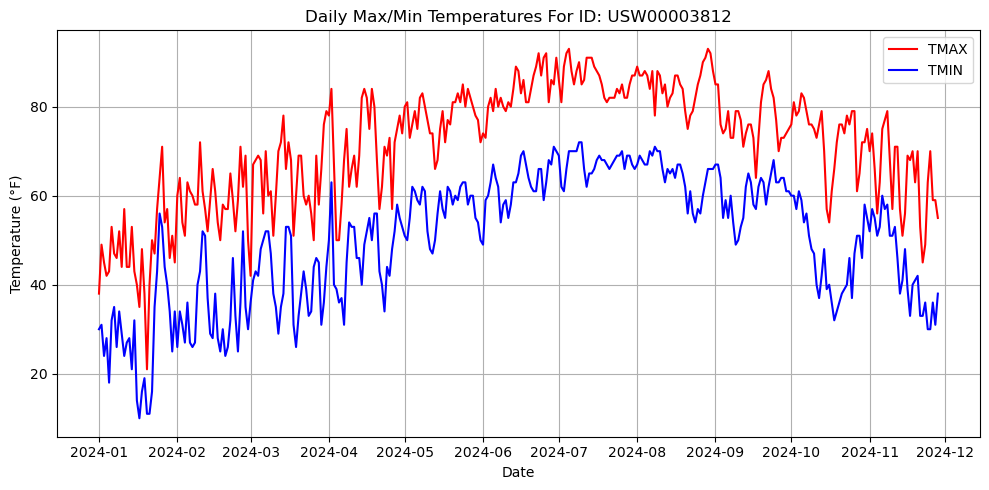

In [8]:
# PLOT
plt.figure(figsize=(10, 5))
plt.plot(inData['date'], inData['TMAX'], color='red', label='TMAX')
plt.plot(inData['date'], inData['TMIN'], color='blue', label='TMIN')

# Format Plot
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.title('Daily Max/Min Temperatures For ID: '+ghcndID)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()